为了比较多层感知器和单个感知器，我们会在与之前相同的玩具数据上执行操作：

## 数据预处理

In [1]:
from sklearn.datasets.samples_generator import make_blobs
X_raw, y_raw = make_blobs(n_samples=100, centers=2,
                          cluster_std=5.2, random_state=42)

import numpy as np
X = X_raw.astype(np.float32)

需要找到一种方式来表示目标标签，不是用整数，而是用一位有效编码。实现这个任务的最简单方式是使用scikit-learn的preprocessing模块：

In [2]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, dtype=np.float32,categories='auto')
y = enc.fit_transform(y_raw.reshape(-1, 1))

## 用OpenCV创建一个多层感知器分类器

In [3]:
import cv2
mlp = cv2.ml.ANN_MLP_create()

但是，现在我们需要指定网络中有多少层，以及每一层有多少个神经元。我们用一个指定每一层神经元数的整数列表来完成这个任务。因为数据矩阵X有两个特征，所以第一层也应该有两个神经元（n_input）。因为输出有两个不同的值，所以最后一层也应该有两个神经元（n_output）。

在这两层之间，我们可以放置任意多个隐藏层以及任意多的神经元。让我们选择一个有10个神经元（n_hidden）的隐藏层：

In [4]:
n_input = 2
n_hidden = 10
n_output = 2
mlp.setLayerSizes(np.array([n_input, n_hidden, n_output]))

## 自定义多层感知器分类器

在我们继续训练分类器之前，我们可以通过一些可选设置来自定义多层感知器分类器：
- mlp.setActivationFunction：这个设置定义了网络中每个神经元所使用的激活函数。
- mlp.setTrainMethod：这个设置定义了一个合适的训练方法。
- mlp.setTermCriteria：这设置了训练阶段的终止条件。

虽然我们自定义的感知器分类器使用的是一个线性激活函数，但是OpenCV提供了另外两个选项：
- cv2.ml.ANN_MLP_IDENTITY：这是线性激活函数f(x) = x。
- cv2.ml.ANN_MLP_SIGMOID_SYM：这是对称的S型函数（也称为双曲正切函数）f(x) = β(1–exp(–αx))/(1+exp(–αx))，其中α控制函数的斜率，β定义输出的上界和下界。
- cv2.ml.ANN_GAUSSIAN：这是高斯函数（也称为钟形曲线）f(x) = βexp(–αx2)。其中α控制函数的斜率，β定义了输出的上界。

在本例中，我们将使用一个合适的S型函数，它将输入值压缩到\[0, 1]范围内。我们选择α = 2.5和β = 1.0来实现这一任务，α和β是激活函数的两个参数，它们的默认值设置为0：

Text(0, 0.5, 'y')

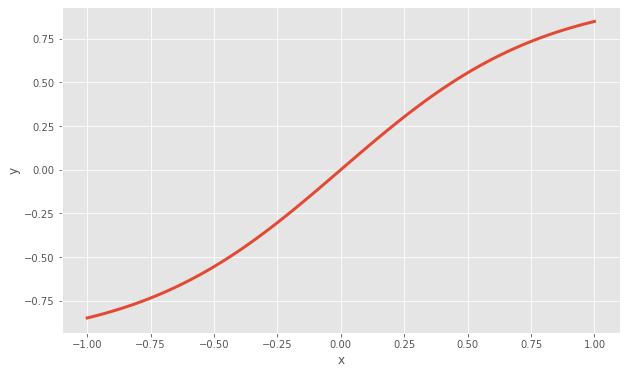

In [5]:
mlp.setActivationFunction(cv2.ml.ANN_MLP_SIGMOID_SYM, 2.5, 1.0)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
alpha = 2.5
beta = 1.0
x_sig = np.linspace(-1.0, 1.0, 100)
y_sig = beta * (1.0 - np.exp(-alpha * x_sig))
y_sig /= (1 + np.exp(-alpha * x_sig))
plt.figure(figsize=(10, 6))
plt.plot(x_sig, y_sig, linewidth=3)
plt.xlabel('x')
plt.ylabel('y')

在本例中，我们将选择反向传播：

In [6]:
mlp.setTrainMethod(cv2.ml.ANN_MLP_BACKPROP)

通过mlp.setTermCriteria指定训练结束必须满足的条件。这对于OpenCV中的每个分类器都是相同的，并且与底层C++功能密切相关。我们先告诉OpenCV我们要指定哪些条件（例如，最大迭代次数）。然后我们再为这个条件指定值。所有值都必须以元组的形式传递。因此，为了使我们的多层感知器分类器运行到迭代次数达到300次或者误差不再增加，以至超出一些小范围的值，我们可以编写以下内容：

In [7]:
term_mode = cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS
term_max_iter = 300
term_eps = 0.01
mlp.setTermCriteria((term_mode, term_max_iter, term_eps))

## 训练和测试MLP分类器

In [8]:
mlp.train(X, cv2.ml.ROW_SAMPLE, y)
_, y_hat = mlp.predict(X)

from sklearn.metrics import accuracy_score
accuracy_score(y_hat.round(), y)

0.85

这看上去我们可以用一个由10个隐藏层神经元和2个输出神经元组成的一个MLP将单个感知器的性能从81%提升到85%。为了解发生了哪些变化，我们可以再看看决策边界：

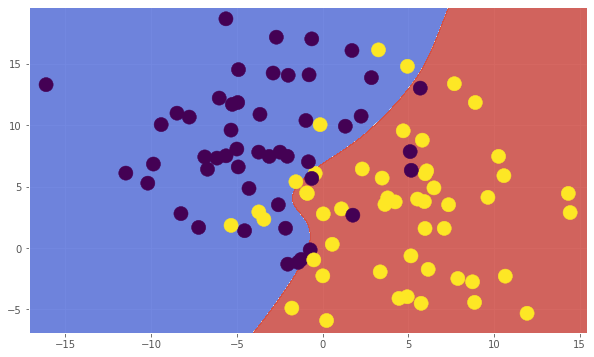

In [9]:
def plot_decision_boundary(classifier, X_test, y_test):
    # create a mesh to plot in
    h = 0.02  # step size in mesh
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    X_hypo = np.c_[xx.ravel().astype(np.float32),
                   yy.ravel().astype(np.float32)]
    _, zz = classifier.predict(X_hypo)
    
    # zz现在是独热编码矩阵。为了将独热编码转换为对应于类标签的一个数字（0或者1），我们可以使用NumPy的argmax函数：
    zz = np.argmax(zz, axis=1)
    zz = zz.reshape(xx.shape)
    
    plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=200)

plt.figure(figsize=(10, 6))
plot_decision_boundary(mlp, X, y_raw)